
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model loaded from disk


<IPython.core.display.Javascript object>

number 0
just came/...
1/1 [==============================] - 1s 823ms/step
>>preds>> [9.979676e-07]
Saved to photo.jpg


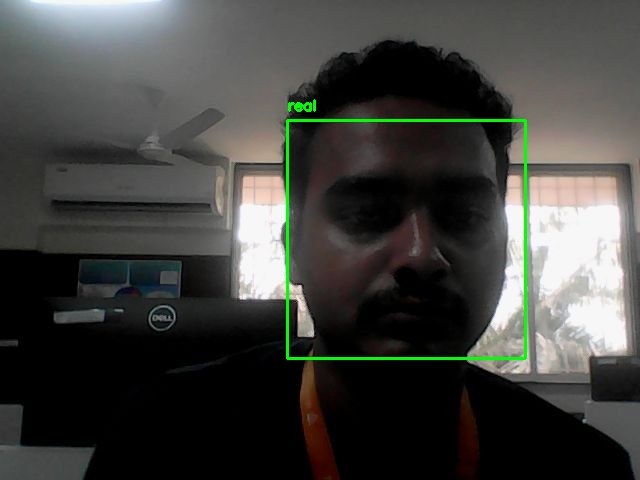

result>> real
0 Login time
emailsent to MANIKANT
number 0
just came/...
1/1 [==============================] - 0s 25ms/step
>>preds>> [0.00018371]
Saved to photo.jpg


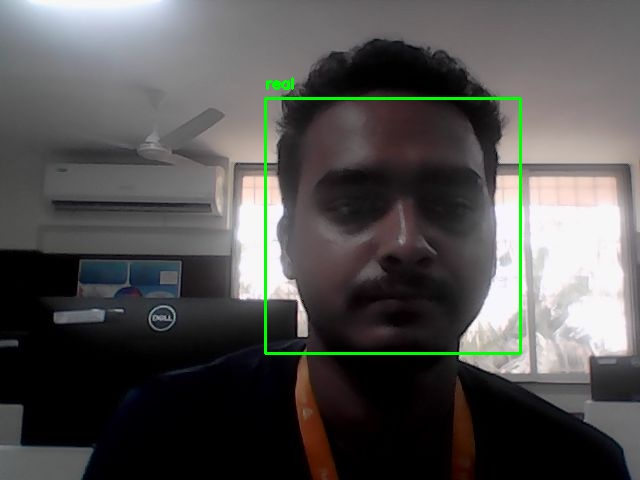

result>> real
1 <<
1 Logout time
emailsent to MANIKANT


In [16]:
#FINAL PROJECT CODE

#--------CODE FOR INPUT IMAGE TAKING-----------------
print()
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
# import html
import time
import os
!pip install tensorflow
from tensorflow.keras.models import model_from_json
import smtplib
import ssl
from email.message import EmailMessage
from datetime import datetime
import collections
from pytz import timezone
!pip install face_recognition
import concurrent.futures
import face_recognition
import os
import shutil
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
# Load known faces
known_faces_dir = "/content/drive/MyDrive/RealTimeFaceRecognitionBasedAttendanceMonitoringSystem/face_recognition/"
known_face_names = []
known_face_encodings = []
resulted_founded_names = []
d = collections.defaultdict(lambda : 'Not found')#['manikantthakur97@gmail.com','20R25A0421'] )
d ['MANIKANT'] = ['manikantthakur97@gmail.com','19R21A04K7'] ;       d['Hari'] = ['1032170857@tcetmumbai.in' ,'19R21A04K2']
d ['VIKAS']  = ['1032231058@tcetmumbai.in','20R25A0421'] ;  d['MANI']  = ['hellomanikantthakur@gmail.com', '20R25A0420']
d ['VIKAS1']  = ['1032231058@tcetmumbai.in','20R25A0421'] ; d ['VIKAS2']  = ['1032231058@tcetmumbai.in','20R25A0421']
curr_folder_path = "/content/drive/MyDrive/RealTimeFaceRecognitionBasedAttendanceMonitoringSystem/Face_Antispoofing_System-main/"

root_dir = os.getcwd()
# Load Face Detection Model
face_cascade = cv2.CascadeClassifier("models/haarcascade_frontalface_default.xml")
# Load Anti-Spoofing Model graph
json_file = open(curr_folder_path+'antispoofing_models/antispoofing_model.json','r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load antispoofing model weights
model.load_weights(curr_folder_path+'antispoofing_models/antispoofing_model.h5')
print("Model loaded from disk")
#
#-------CODE for Recognition and attendance marking---
for filename in os.listdir(known_faces_dir):
    if not filename.startswith('.'):
        image = face_recognition.load_image_file(os.path.join(known_faces_dir, filename))
        face_encodings = face_recognition.face_encodings(image, num_jitters=10, model="large")
        if face_encodings:
            known_face_encodings.append(face_encodings[0])
            known_face_names.append(os.path.splitext(filename)[0])

# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image
  for (x,y,w,h) in faces:
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # save image
  cv2.imwrite(filename, img)

  return filename

# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data


# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0
i =0
reali = 0 ; name = "" ; label = "Proxy" ; resulted_founded_names = []
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        i = 0 ; reali = 0
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    #
    frame = img
    #

    # grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    try:
      faces = face_cascade.detectMultiScale(gray,1.3,5)
      for (x,y,w,h) in faces:
        print("number",i); i+=1
        face = frame[y-5:y+h+5,x-5:x+w+5]
        resized_face = cv2.resize(face,(160,160))
        resized_face = resized_face.astype("float") / 255.0
        # resized_face = img_to_array(resized_face)
        resized_face = np.expand_dims(resized_face, axis=0)
        # pass the face ROI through the trained liveness detector
        # model to determine if the face is "real" or "Proxy"
        print("just came/...")
        preds = model.predict(resized_face)[0]
        print(">>preds>>",preds)
        if preds> 0.5:
            label = 'spoof'
            cv2.putText(frame, label, (x,y - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 2)
            cv2.rectangle(frame, (x, y), (x+w,y+h),
                (0, 0, 255), 2)
        else:
            label = 'real'
            reali += 1
            cv2.putText(frame, label, (x,y - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)
            cv2.rectangle(frame, (x, y), (x+w,y+h),
            (0, 255, 0), 2)
        # save image
        filename = "photo.jpg"
        cv2.imwrite(filename, frame)
        print('Saved to {}'.format(filename))
        display(Image(filename))
        print("result>>",label)
    except: pass
#----------------------------------------------------
    if label =='real':
      label = "Proxy"
      # Load test image
      test_image_path = "/content/photo.jpg"
      test_image = face_recognition.load_image_file(test_image_path)

      # Define face recognition function
      def recognize_face(face_encoding):
          matches = face_recognition.compare_faces(known_face_encodings, face_encoding, tolerance=0.4)
          if True in matches:
              match_index = matches.index(True)
              name = known_face_names[match_index]
              return name
          else:
              return None

      # Find faces in test image
      face_locations = face_recognition.face_locations(test_image, model='cnn')
      face_encodings = face_recognition.face_encodings(test_image, face_locations, num_jitters=10, model="large")

      # Create or open attendance file in append mode
      attendance_file = open("/content/drive/MyDrive/AutoMailingFeatureForAttendanceSystem/attendance.txt", "a")

      # Check if test image contains at least one face
      if not face_encodings:
          print("No faces found in test image.")
      else:
          # Parallelize face recognition process
          with concurrent.futures.ProcessPoolExecutor() as executor:
              results = executor.map(recognize_face, face_encodings)
          resulted_founded_names = list(results)
          # Write attendance to file
          for i, result in enumerate(results):
              if result:
                  name = result
                  resulted_founded_names.append(name)
                  print(f"Match found: {name}")

              else:
                  print("No match found.")
      #-----------------------------------------------------

    #--------CODE FOR EMAIL SENDING ----------------------
    for name in resulted_founded_names:
      try:
      ##################################
        def update_login(student_name):
          file_path = '/content/drive/MyDrive/Attendance Folder/login.txt'
          # student_name = input("Enter student name: ")

          with open(file_path, 'r') as file:
              lines = file.readlines()
          # print("initial>",lines)

          found = 0
          new_lines = []

          for line in lines:
              if line.strip() == student_name:
                  found = 1
                  print(found,"<<")
                  continue
              else:
                  new_lines.append(line)

          if not found:
              new_lines.append(student_name + '\n')

          with open(file_path, 'w') as file:
              file.writelines(new_lines)

          with open(file_path, 'r') as file:
              lines = file.readlines()
          return found
          # print("final>",lines)
        ##################################
        # Get the current date and time
        now = datetime.now(timezone("Asia/Kolkata"))
        current_time = now.strftime("%H:%M:%S")
        current_date = now.strftime("%d/%m/%Y")
        founded = update_login(name)
        res_loginRout = "Login time"
        if founded:
            attendance_file.write(f"{name} logout marked on {current_date} at {current_time}\n")
            res_loginRout = "Logout time"
        else:
            attendance_file.write(f"{name} login marked on {current_date} at {current_time}\n")
        attendance_file.close() # Close attendance file
        print(founded,res_loginRout)
        for i in range(1):

          # for i in range(10):
          # Define email sender and receiver
          email_sender = 'manikantthakur97@gmail.com'#'manikantthakur97@gmail.com'#'manikantthakur97@gmail.com'
          email_password = 'jnzxcglmwwgnfbyz'#'tkldvzvmttkwtcvv'#'ncwxbldpctyvzwjb'
          email_receiver = d[name][0]#'skgouse131@gmail'#'1032231058@tcetmumbai.in'#'1032231058@tcetmumbai.in'#'1032231058@tcetmumbai.in'

          # Set the subject and body of the email
          subject = 'SSNV Organisation REAL-TIME FACE RECOGNITION BASED ATTENDANCE MONITORING SYSTEM.'#'Check out Your ward attendance!'
          body = f"""
          <<<<<<<<<<<<<   YOUR ATTENDANCE   >>>>>>>>>>>>>>>
          -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
          RollNo : {d[name][1]}
          NAME : {name}
          DATE : {current_date}
          TIME : {current_time}
          {name} {res_loginRout} attended on {current_date} at {current_time} has successfully marked the attendance.
          ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
          Dear {d[name][0]}, \n
          This message is from Organisation/college automatic attendance system. \n
          Your attendance has been successfully marked using the face recognition system. This means that you have been present and accounted for during work hours. I would like to take this opportunity to congratulate you on your successful use of the system.
          \n
          The face recognition system has also enhanced our security measures, as it only allows authorized personnel with registered faces to enter the premises. This ensures that our workplace remains safe and secure at all times.
          \n
          As a Organisation/college attendance system would like to remind you to continue using the face recognition system for attendance marking. It is important that we maintain accurate attendance records to ensure that everyone is accounted for during work hours..
          \n
          Thank you for your attention to this matter.
          \n
          Best regards,
          \n
          {name}"""

          em = EmailMessage()
          em['From'] = 'XYZ'#email_sender
          em['To'] = email_receiver
          em['Subject'] = subject
          em.set_content(body)

          # Add SSL (layer of security)
          context = ssl.create_default_context()

          # Log in and send the email
          with smtplib.SMTP_SSL('smtp.gmail.com', 465, context=context) as smtp:
              smtp.login(email_sender, email_password)
              smtp.sendmail(email_sender, email_receiver, em.as_string())
          print(f"emailsent to {name}")
      except:
        print("NO match found")
      resulted_founded_names = []
    #------------------------------------------------------------------------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
